In [33]:
!pip install numpy pandas rdkit chembl_webresource_client tqdm matplotlib scikit-learn

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import sklearn


In [34]:
#Define the target protein name with its project id
TARGET_NAME="ACHE(Acetylcholinesterase)"
TARGET_ID='CHEMBL220'

In [35]:
targets_api=new_client.target
compounds_api=new_client.molecule
bioactivities_api=new_client.activity

In [36]:
#use .get() to directly fetch the target by its ID
selected_target=targets_api.get(TARGET_ID)


In [37]:
#checking if the organism of our desired target is Homo sapiens
if selected_target:
  if 'Homo sapiens' in selected_target['organism']:
    print(f"Successfully found target: {selected_target['pref_name']}")
    print(f"Oragnism: {selected_target['organism']}")
    print(f"ChEMBL ID: {selected_target['target_chembl_id']}\n")
  else:
    print(f"Found target {TARGET_ID},but its not for Homo sapiens")
    print(f"Organism:{selected_target['organism']}")
else:
  print(f"No target ID is found with this'{TARGET_ID}")

Successfully found target: Acetylcholinesterase
Oragnism: Homo sapiens
ChEMBL ID: CHEMBL220



In [38]:
#filtering IC50 data
bioactivities=bioactivities_api.filter(target_chembl_id=selected_target['target_chembl_id']).filter(standard_type="IC50")

In [39]:
bioactivities_df=pd.DataFrame(bioactivities)
bioactivities_df.head(5)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8


In [40]:
print(f"Retrieved {len(bioactivities_df)} bioactivity entries")


Retrieved 9415 bioactivity entries


In [55]:
#data cleaning and filtering
df2=bioactivities_df[["molecule_chembl_id","canonical_smiles","standard_value","standard_units","standard_type"]]
df=df2.dropna(subset=["standard_value"])
df=df[df["standard_units"]=="nM"]
print(f"After cleaning, we have {len(df)} entries to analyse")

df

After cleaning, we have 8080 entries to analyse


,molecule_chembl_id,canonical_smiles,standard_value,standard_units,standard_type
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,nM,IC50
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,nM,IC50
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,nM,IC50
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,nM,IC50
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,nM,IC50
...,...,...,...,...,...
9410,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,46000.0,nM,IC50
9411,CHEMBL11298,N[C@@H](CO)C(=O)O,38310.0,nM,IC50
9412,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,1710.0,nM,IC50
9413,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,10000.0,nM,IC50


In [65]:
#convert the standard value to numeric type to avoid TypeError and creating a dataframe for PI50
df2.loc[:,"standard_value"]=pd.to_numeric(df2["standard_value"],errors="coerce")
df2.dropna(subset=["standard_value"]).copy()
df2=df2[df2["standard_value"]!=0].copy()
df2.loc[:,"pIC50"]=-np.log10(df2["standard_value"]*1e-9)
df2

,molecule_chembl_id,canonical_smiles,standard_value,standard_units,standard_type,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,nM,IC50,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,nM,IC50,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,nM,IC50,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,nM,IC50,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,nM,IC50,6.096910
...,...,...,...,...,...,...
9410,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,46000.0,nM,IC50,4.337242
9411,CHEMBL11298,N[C@@H](CO)C(=O)O,38310.0,nM,IC50,4.416688
9412,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,1710.0,nM,IC50,5.767004
9413,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,10000.0,nM,IC50,5.000000


In [66]:
#data preprocessing of the bioactivity data
#by labelling as either active,inactive or intermediate
bioactivity_class=[]
for i in df2 ["standard_value"]:
  if  float(i)>=10000:
    bioactivity_class.append("inactive")
  elif  float(i)<=1000:
    bioactivity_class.append("active")
  else:
    bioactivity_class.append("intermediate")


In [67]:
df2['bioactivity_class']=bioactivity_class
df2

,molecule_chembl_id,canonical_smiles,standard_value,standard_units,standard_type,pIC50,bioactivity_class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,nM,IC50,6.124939,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,nM,IC50,7.000000,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,nM,IC50,4.301030,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,nM,IC50,6.522879,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,nM,IC50,6.096910,active
...,...,...,...,...,...,...,...
9410,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,46000.0,nM,IC50,4.337242,inactive
9411,CHEMBL11298,N[C@@H](CO)C(=O)O,38310.0,nM,IC50,4.416688,inactive
9412,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,1710.0,nM,IC50,5.767004,intermediate
9413,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,10000.0,nM,IC50,5.000000,inactive


In [68]:
final_df=df2[["molecule_chembl_id","canonical_smiles","standard_value","pIC50","bioactivity_class"]].sort_values(by="pIC50",ascending=False)
final_df

,molecule_chembl_id,canonical_smiles,standard_value,pIC50,bioactivity_class
7175,CHEMBL4455677,COc1ccc2[nH]cc(CCNC(=O)CCCCNc3c4c(nc5ccccc35)C...,5.000000e-06,14.301030,active
7174,CHEMBL4543251,O=C(CCCCCNc1c2c(nc3ccc(F)cc13)CCCC2)NCCc1c[nH]...,5.000000e-06,14.301030,active
7176,CHEMBL199454,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5ccccc35)...,5.000000e-06,14.301030,active
7177,CHEMBL382260,COc1ccc2[nH]cc(CCNC(=O)CCCCCCNc3c4c(nc5ccccc35...,5.000000e-06,14.301030,active
7178,CHEMBL4532770,COc1ccc2[nH]cc(CCNC(=O)CCCCCCCNc3c4c(nc5ccccc3...,5.000000e-06,14.301030,active
...,...,...,...,...,...
5362,CHEMBL3597055,COC(=O)C1=C(Nc2ccc(F)cc2)C[C@@H](c2ccccc2)N(c2...,1.512000e+07,1.820448,inactive
2703,CHEMBL1276534,O=C(NP(=O)(NN1CCOCC1)NN1CCOCC1)c1ccccc1,1.862000e+07,1.730020,inactive
1895,CHEMBL51628,O=c1ccc2ccc(O)cc2o1,2.900000e+07,1.537602,inactive
1367,CHEMBL371798,CN(CCCCCCCOc1ccc2c(c1)O/C(=C\c1cccc3ccccc13)C2...,4.960000e+07,1.304518,inactive


In [69]:
#visualize the pIC50 Distribution by filtering out infinite pIC50 values before plotting
finite_values=final_df[np.isfinite(final_df["pIC50"])]


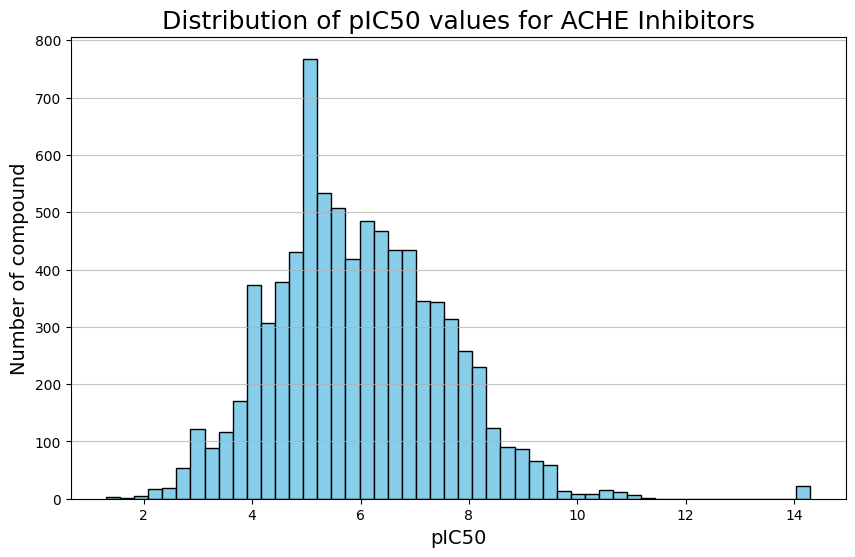

In [70]:
#create a histogram plot using finite values of pIC50
plt.figure(figsize=(10,6))
plt.hist(finite_values['pIC50'],bins=50,color="skyblue",edgecolor="black")
plt.title("Distribution of pIC50 values for ACHE Inhibitors",fontsize=18)
plt.xlabel("pIC50",fontsize=14)
plt.ylabel("Number of compound",fontsize=14)
plt.grid(axis="y",alpha=0.75)
plt.show()

In [71]:
#calculate aromatic rings from descriptors
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcNumAromaticRings
def aromatic_number(smiles):
  if not isinstance (smiles,str):
    return 0
  mol = Chem.MolFromSmiles(smiles)
  if mol is None:
    return 0
  return CalcNumAromaticRings(mol)
final_df["canonical_smiles"]=final_df["canonical_smiles"].fillna('')
final_df["NumAromaticRings"]=final_df["canonical_smiles"].apply(aromatic_number)
final_df

,molecule_chembl_id,canonical_smiles,standard_value,pIC50,bioactivity_class,NumAromaticRings
7175,CHEMBL4455677,COc1ccc2[nH]cc(CCNC(=O)CCCCNc3c4c(nc5ccccc35)C...,5.000000e-06,14.301030,active,4
7174,CHEMBL4543251,O=C(CCCCCNc1c2c(nc3ccc(F)cc13)CCCC2)NCCc1c[nH]...,5.000000e-06,14.301030,active,4
7176,CHEMBL199454,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5ccccc35)...,5.000000e-06,14.301030,active,4
7177,CHEMBL382260,COc1ccc2[nH]cc(CCNC(=O)CCCCCCNc3c4c(nc5ccccc35...,5.000000e-06,14.301030,active,4
7178,CHEMBL4532770,COc1ccc2[nH]cc(CCNC(=O)CCCCCCCNc3c4c(nc5ccccc3...,5.000000e-06,14.301030,active,4
...,...,...,...,...,...,...
5362,CHEMBL3597055,COC(=O)C1=C(Nc2ccc(F)cc2)C[C@@H](c2ccccc2)N(c2...,1.512000e+07,1.820448,inactive,4
2703,CHEMBL1276534,O=C(NP(=O)(NN1CCOCC1)NN1CCOCC1)c1ccccc1,1.862000e+07,1.730020,inactive,1
1895,CHEMBL51628,O=c1ccc2ccc(O)cc2o1,2.900000e+07,1.537602,inactive,2
1367,CHEMBL371798,CN(CCCCCCCOc1ccc2c(c1)O/C(=C\c1cccc3ccccc13)C2...,4.960000e+07,1.304518,inactive,4


In [72]:
#calculate hydrogen bonds donors and acceptors
from rdkit.Chem import Descriptors
#calculate hydrogen bonds donors
def hydrogen_d(smiles):
  if not isinstance(smiles,str):#ensure the input is string
    return 0
  mol=Chem.MolFromSmiles(smiles)
  if mol is None:#ensure the smile string is valid
    return 0
  return Descriptors.NumHDonors(mol)
#calculate hydrogen bond acceptors
def hydrogen_a(smiles):
  if not isinstance(smiles,str):#ensure the input is string
    return 0
  mol=Chem.MolFromSmiles(smiles)
  if mol is None:#ensure the smile string is valid
    return 0
  return Descriptors.NumHAcceptors(mol)
#fill any NaN or none values in "canonical_smiles" with an empty string to prevent errors
final_df["canonical_smiles"] = final_df["canonical_smiles"].fillna("")
#apply the functions to this column
final_df["NumHDonors"]=final_df["canonical_smiles"].apply(hydrogen_d)
final_df["NumHAcceptors"]=final_df["canonical_smiles"].apply(hydrogen_a)
final_df

,molecule_chembl_id,canonical_smiles,standard_value,pIC50,bioactivity_class,NumAromaticRings,NumHDonors,NumHAcceptors
7175,CHEMBL4455677,COc1ccc2[nH]cc(CCNC(=O)CCCCNc3c4c(nc5ccccc35)C...,5.000000e-06,14.301030,active,4,3,4
7174,CHEMBL4543251,O=C(CCCCCNc1c2c(nc3ccc(F)cc13)CCCC2)NCCc1c[nH]...,5.000000e-06,14.301030,active,4,3,3
7176,CHEMBL199454,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5ccccc35)...,5.000000e-06,14.301030,active,4,3,4
7177,CHEMBL382260,COc1ccc2[nH]cc(CCNC(=O)CCCCCCNc3c4c(nc5ccccc35...,5.000000e-06,14.301030,active,4,3,4
7178,CHEMBL4532770,COc1ccc2[nH]cc(CCNC(=O)CCCCCCCNc3c4c(nc5ccccc3...,5.000000e-06,14.301030,active,4,3,4
...,...,...,...,...,...,...,...,...
5362,CHEMBL3597055,COC(=O)C1=C(Nc2ccc(F)cc2)C[C@@H](c2ccccc2)N(c2...,1.512000e+07,1.820448,inactive,4,1,4
2703,CHEMBL1276534,O=C(NP(=O)(NN1CCOCC1)NN1CCOCC1)c1ccccc1,1.862000e+07,1.730020,inactive,1,3,6
1895,CHEMBL51628,O=c1ccc2ccc(O)cc2o1,2.900000e+07,1.537602,inactive,2,1,3
1367,CHEMBL371798,CN(CCCCCCCOc1ccc2c(c1)O/C(=C\c1cccc3ccccc13)C2...,4.960000e+07,1.304518,inactive,4,1,5


In [73]:
#calculate the value for logP and molecular weight
# Function to calculate the value for logP
def logP(smiles):
  if not isinstance(smiles,str):
    return 0
  mol=Chem.MolFromSmiles(smiles)
  if mol is None:
    return 0
  return Descriptors.MolLogP(mol)

#Function to calculate molecular weight
def mol_wt(smiles):
  if not isinstance(smiles,str):
    return 0
  mol=Chem.MolFromSmiles(smiles)
  if mol is None:
    return 0
  return Descriptors.MolWt(mol)

final_df["MolLogP"]=final_df["canonical_smiles"].apply(logP)
final_df["MolWt"]=final_df["canonical_smiles"].apply(mol_wt)
final_df


,molecule_chembl_id,canonical_smiles,standard_value,pIC50,bioactivity_class,NumAromaticRings,NumHDonors,NumHAcceptors,MolLogP,MolWt
7175,CHEMBL4455677,COc1ccc2[nH]cc(CCNC(=O)CCCCNc3c4c(nc5ccccc35)C...,5.000000e-06,14.301030,active,4,3,4,5.5446,470.617
7174,CHEMBL4543251,O=C(CCCCCNc1c2c(nc3ccc(F)cc13)CCCC2)NCCc1c[nH]...,5.000000e-06,14.301030,active,4,3,3,6.0652,472.608
7176,CHEMBL199454,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5ccccc35)...,5.000000e-06,14.301030,active,4,3,4,5.9347,484.644
7177,CHEMBL382260,COc1ccc2[nH]cc(CCNC(=O)CCCCCCNc3c4c(nc5ccccc35...,5.000000e-06,14.301030,active,4,3,4,6.3248,498.671
7178,CHEMBL4532770,COc1ccc2[nH]cc(CCNC(=O)CCCCCCCNc3c4c(nc5ccccc3...,5.000000e-06,14.301030,active,4,3,4,6.7149,512.698
...,...,...,...,...,...,...,...,...,...,...
5362,CHEMBL3597055,COC(=O)C1=C(Nc2ccc(F)cc2)C[C@@H](c2ccccc2)N(c2...,1.512000e+07,1.820448,inactive,4,1,4,7.1967,496.557
2703,CHEMBL1276534,O=C(NP(=O)(NN1CCOCC1)NN1CCOCC1)c1ccccc1,1.862000e+07,1.730020,inactive,1,3,6,0.1981,369.362
1895,CHEMBL51628,O=c1ccc2ccc(O)cc2o1,2.900000e+07,1.537602,inactive,2,1,3,1.4986,162.144
1367,CHEMBL371798,CN(CCCCCCCOc1ccc2c(c1)O/C(=C\c1cccc3ccccc13)C2...,4.960000e+07,1.304518,inactive,4,1,5,7.6229,521.657


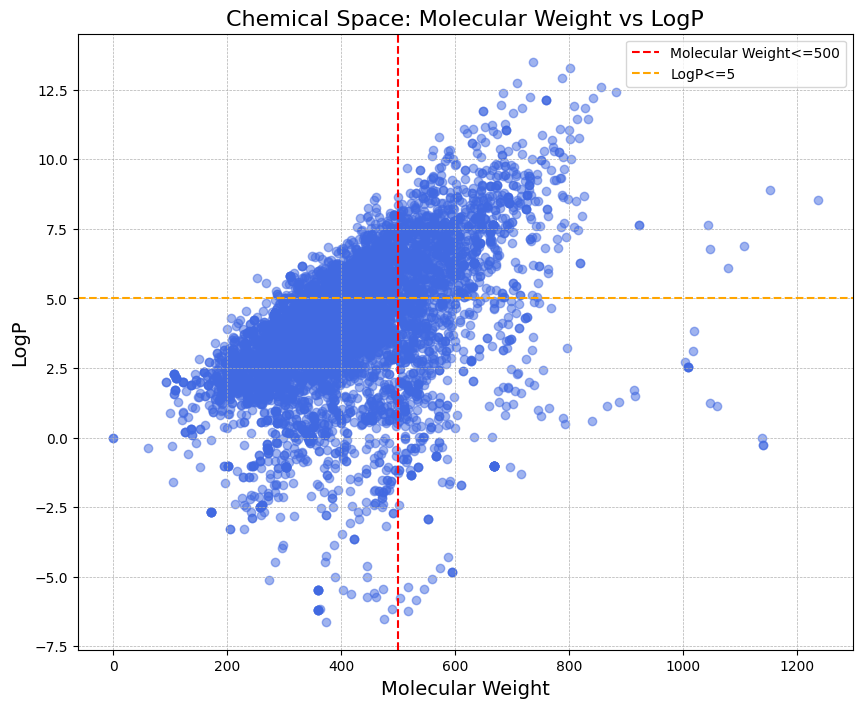

In [74]:
#visualize chemical space (Molecular weight vs LogP)
plt.figure(figsize=(10,8))
#create a scatter plot
plt.scatter(x=final_df["MolWt"],y=final_df["MolLogP"],alpha=0.5,color="royalblue")
#add a title and labels
plt.title("Chemical Space: Molecular Weight vs LogP",fontsize=16)
plt.xlabel("Molecular Weight",fontsize=14)
plt.ylabel("LogP",fontsize=14)
#add Lipinski's Rule of Five boundaries
plt.axvline(x=500,color="red",linestyle="--",label="Molecular Weight<=500")
plt.axhline(y=5,color="orange",linestyle="--",label="LogP<=5")
plt.legend()
#add grid
plt.grid(True,which="both",linestyle="--",linewidth=0.5)
plt.show()


In [75]:
#saving the dataframe to a CSV file
final_df.to_csv("ache_inhibitors.csv",index=False)
print("The file is saved successfully")

The file is saved successfully


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
#build a machine learning model for pIC50 prediction
"""filter out the rows where pIC50  is not a finite  number """
filtered_df=final_df[np.isfinite(final_df["pIC50"])].copy()
#prepare the data : Select features (X) and target (y)
features=["NumAromaticRings","MolWt","MolLogP","NumHDonors","NumHAcceptors"]
x=filtered_df[features]
y=filtered_df["pIC50"]
#split the data:80% for training, 20% for testing
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
print(f"Training set size: {x_train.shape[0]} samples")
print(f"Testing set size: {x_test.shape[0]} samples")
#train the model : Use a RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(x_train,y_train)
#evaluate the model on the test data
y_pred=model.predict(x_test)
r2=r2_score(y_test,y_pred)
print(f"R squared R^2 score: {r2:.2f}")

Training set size: 6503 samples
Testing set size: 1626 samples
R squared R^2 score: 0.43


In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
#hyperparameter tuning with cross validation
"""this step systematically finds the best combination of parameters for the model and provides more reliable evaluation of its performance"""
#define the range of parameters to test
param_grid={
    "n_estimators":[50,100,200],
    "max_depth":[10,20,30,None],
    "min_samples_leaf":[1,2,4]
}
#create a neew instance for RandomforestRegressor model
rf_model=RandomForestRegressor(random_state=42)
#set up the GridSearchCV object
grid_search=GridSearchCV(estimator=rf_model,param_grid=param_grid,cv=5,scoring="r2",n_jobs=-1)
#fit the grid search to your training data. this will run the tuning process
grid_search.fit(x_train,y_train)
#finding the best parameters found by grid search
print(f"best parameters:{grid_search.best_params_}")
#get the best model from the grid search
best_model=grid_search.best_estimator_
#make predictions on the unseen data using the best model
y_pred_tuned=best_model.predict(x_test)
#calculate the R squared score of the best model on the test set
r2_tuned=r2_score(y_test,y_pred_tuned)
#print the final R- squared score
print(f"R-squared with tuned model on the test set: {r2_tuned:.2f}")

best parameters:{'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 200}
R-squared with tuned model on the test set: 0.43
